# Monthly Accuracy Assessment of Water Observations from Space (WOfS) Product in Africa<img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

## Description
Now that we have run WOfS classification for each AEZs in Africa, its time to conduct seasonal accuracy assessment for each AEZ in Africa which is already compiled and stored in the following folder:`Results/WOfS_Assessment/Point_Based/ValidPoints_Per_AEZ`.

Accuracy assessment for WOfS product in Africa includes generating a confusion error matrix for a WOFL binary classification.
The inputs for the estimating the accuracy of WOfS derived product are a binary classification WOFL layer showing water/non-water and a shapefile containing validation points collected by [Collect Earth Online](https://collect.earth/) tool. Validation points are the ground truth or actual data while the extracted value for each location from WOFL is the predicted value. 

This notebook will explain how you can perform seasonal accuracy assessment for WOfS starting with `Western` AEZ using collected ground truth dataset. It will output a confusion error matrix containing overall, producer's and user's accuracy, along with the F1 score for each class.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import os
import rasterio
import xarray
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

sys.path.append("../Scripts")
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import plot_confusion_matrix, f1_score  
from deafrica_tools.plotting import map_shapefile,display_map, rgb
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.datahandling import wofs_fuser, mostcommon_crs,load_ard,deepcopy
from deafrica_tools.dask import create_local_dask_cluster

### Analysis Parameters 

- CEO : groundtruth points containing valid points in each AEZ containing WOfS assigned classes, WOfS clear observations and the labels identified by analyst in each calendar month 
- input_data : dataframe for further analysis and accuracy assessment 

### Load the Dataset

Validation points that are valid for each AEZ  

In [2]:
accuracies = {}
months = np.arange(1,13)
def monthly_accuracy(aez_name):
    CEO = f'../Results/WOfS_Assessment/Point_Based/{aez_name}_S2_WOfS.csv'
    input_data = pd.read_csv(CEO,delimiter=",")
    input_data=input_data.drop(['Unnamed: 0'], axis=1)
    working = {}
    for i in months:
        is_month = input_data["MONTH"]==i
        monthly = input_data[is_month]
        if len(monthly)>=7:
            confusion_matrix = pd.crosstab(monthly['ACTUAL'],monthly['PREDICTION'],
                                           rownames=['ACTUAL'],colnames=['PREDICTION'],margins=True)
            confusion_matrix["Producer's"] = [confusion_matrix.loc[0][0] / confusion_matrix.loc[0]['All'] * 100, 
                                              confusion_matrix.loc[1][1] / confusion_matrix.loc[1]['All'] *100, np.nan]
            users_accuracy = pd.Series([confusion_matrix[0][0] / confusion_matrix[0]['All'] * 100,
                                        confusion_matrix[1][1] / confusion_matrix[1]['All'] * 100]).rename("User's")
            confusion_matrix = confusion_matrix.append(users_accuracy)
            confusion_matrix.loc["User's", "Producer's"] = (confusion_matrix[0][0] + confusion_matrix[1][1]) / confusion_matrix['All']['All'] * 100
            input_data['PREDICTION'] = input_data['PREDICTION'] .astype(str).astype(int)
            fscore = pd.Series([(2*(confusion_matrix.loc["User's"][0]*confusion_matrix.loc[0]["Producer's"]) / (confusion_matrix.loc["User's"][0] + confusion_matrix.loc[0]["Producer's"])) / 100,
                           f1_score(input_data['ACTUAL'],input_data['PREDICTION'])]).rename("F-score")
            confusion_matrix = confusion_matrix.append(fscore)
            confusion_matrix = confusion_matrix.round(decimals=2)
            confusion_matrix = confusion_matrix.rename(columns={'0':'NoWater','1':'Water', 0:'NoWater',1:'Water','All':'Total'},
                                                       index={'0':'NoWater','1':'Water',0:'NoWater',1:'Water','All':'Total'})
            working[i]=confusion_matrix
        else:
            #pass
            confusion_matrix = pd.crosstab(monthly['ACTUAL'],monthly['PREDICTION'],
                                           rownames=['ACTUAL'],colnames=['PREDICTION'],margins=True)
            confusion_matrix["Producer's"] = [np.nan, np.nan]
            users_accuracy = pd.Series([np.nan,
                                        np.nan]).rename("User's")
            confusion_matrix = confusion_matrix.append(users_accuracy)
            confusion_matrix.loc["User's", "Producer's"] = np.nan
            input_data['PREDICTION'] = input_data['PREDICTION'] .astype(str).astype(int)
            fscore = pd.Series([np.nan,np.nan]).rename("F-score")
            confusion_matrix = confusion_matrix.append(fscore)
            confusion_matrix = confusion_matrix.round(decimals=2)
            confusion_matrix = confusion_matrix.rename(columns={'0':'NoWater','1':'Water', 0:'NoWater',1:'Water','All':'Total'},
                                                       index={'0':'NoWater','1':'Water',0:'NoWater',1:'Water','All':'Total'})
            working[i]=confusion_matrix
    producer = [] 
    user = []
    overall = []
    for i in months: 
        is_month = input_data["MONTH"]==i
        monthly = input_data[is_month]
        #if len(monthly)>=7:
        producer.append(working[i]["Producer's"][1])
        user.append(working[i]["Water"][3])
        overall.append(working[i]["Producer's"][3])
        #else:
        #    pass
    accuracies[aez_name]={"Producer":producer, "User":user, "Overall":overall}

In [4]:
monthly_accuracy('Central')
monthly_accuracy('Eastern')
monthly_accuracy('Western')
monthly_accuracy('Southern')
monthly_accuracy('Northern')
monthly_accuracy('Sahel')
monthly_accuracy('Indian_ocean')

In [5]:
accuracies['Western']

{'Producer': [69.88,
  68.47,
  76.88,
  52.24,
  50.0,
  61.9,
  77.78,
  81.82,
  66.67,
  87.76,
  94.4,
  87.82],
 'User': [97.48,
  96.2,
  97.08,
  100.0,
  100.0,
  92.86,
  100.0,
  100.0,
  80.0,
  100.0,
  96.72,
  98.56],
 'Overall': [73.5,
  72.26,
  79.05,
  58.97,
  62.5,
  64.0,
  81.82,
  84.0,
  75.0,
  90.0,
  92.47,
  89.01]}

In [17]:
months = np.arange(1,13)


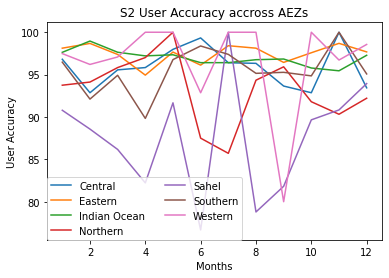

In [6]:
plt.plot(months, accuracies['Central']['User'], label='Central')
plt.plot(months, accuracies['Eastern']['User'], label='Eastern')
plt.plot(months, accuracies['Indian_ocean']['User'], label='Indian Ocean')
plt.plot(months, accuracies['Northern']['User'], label='Northern')
plt.plot(months, accuracies['Sahel']['User'], label='Sahel')
plt.plot(months, accuracies['Southern']['User'], label='Southern')
plt.plot(months, accuracies['Western']['User'], label='Western')
#plt.ylim(0,450)
plt.legend(ncol=2, loc='lower left', borderaxespad=0.)
plt.title('S2 User Accuracy accross AEZs')
plt.xlabel('Months')
plt.ylabel('User Accuracy')
plt.savefig('S2_All_AEZ_montly_user.png')

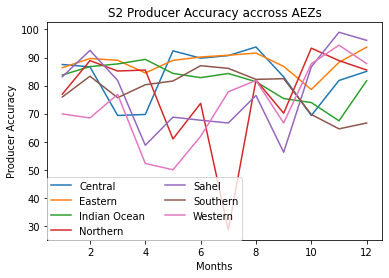

In [8]:
plt.plot(months, accuracies['Central']['Producer'], label='Central')
plt.plot(months, accuracies['Eastern']['Producer'], label='Eastern')
plt.plot(months, accuracies['Indian_ocean']['Producer'], label='Indian Ocean')
plt.plot(months, accuracies['Northern']['Producer'], label='Northern')
plt.plot(months, accuracies['Sahel']['Producer'], label='Sahel')
plt.plot(months, accuracies['Southern']['Producer'], label='Southern')
plt.plot(months, accuracies['Western']['Producer'], label='Western')
#plt.ylim(0,450)
plt.legend(ncol=2, loc='lower left', borderaxespad=0.)
plt.title('S2 Producer Accuracy accross AEZs')
plt.xlabel('Months')
plt.ylabel('Producer Accuracy')
plt.savefig('S2_All_AEZ_montly_producer.png')

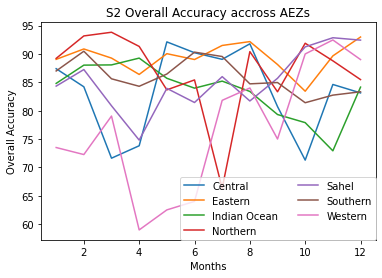

In [9]:
plt.plot(months, accuracies['Central']['Overall'], label='Central')
plt.plot(months, accuracies['Eastern']['Overall'], label='Eastern')
plt.plot(months, accuracies['Indian_ocean']['Overall'], label='Indian Ocean')
plt.plot(months, accuracies['Northern']['Overall'], label='Northern')
plt.plot(months, accuracies['Sahel']['Overall'], label='Sahel')
plt.plot(months, accuracies['Southern']['Overall'], label='Southern')
plt.plot(months, accuracies['Western']['Overall'], label='Western')
#plt.ylim(0,450)
plt.legend(ncol=2, loc='lower right', borderaxespad=0.)
plt.title('S2 Overall Accuracy accross AEZs')
plt.xlabel('Months')
plt.ylabel('Overall Accuracy')
plt.savefig('S2_All_AEZ_montly_overall.png')

In [24]:
#plotting with means and stds

In [24]:
Dry_Season = input_data[~input_data['MONTH'].isin(month)]
Dry_Season

,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLEAR_OBS,PREDICTION
0,137711631.0,17.782114,7.802986,Open water - freshwater,8,0,1.0,2.0,1
1,137711631.0,17.782114,7.802986,Open water - freshwater,10,0,1.0,1.0,1
4,137711631.0,17.782114,7.802986,Open water - freshwater,3,1,1.0,2.0,1
5,137711631.0,17.782114,7.802986,Open water - freshwater,5,1,0.0,1.0,0
7,137711632.0,17.982660,7.455957,Open water - freshwater,6,1,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...
2307,137712354.0,6.631720,4.347916,Open water - marine,8,1,1.0,1.0,1
2308,137712355.0,6.246484,4.329523,Open water - marine,3,1,1.0,1.0,1
2309,137712355.0,6.246484,4.329523,Open water - marine,8,1,1.0,1.0,1
2310,137712355.0,6.246484,4.329523,Open water - marine,11,1,1.0,1.0,1


In [28]:
mean_c = np.mean(accuracies['Central']['User'])
std_c = np.std(accuracies['Central']['User'])

In [26]:
mean_c

94.94666666666666

In [29]:
std_c

2.4988041584370344

Text(24.125, 0.5, 'User Accuracy')

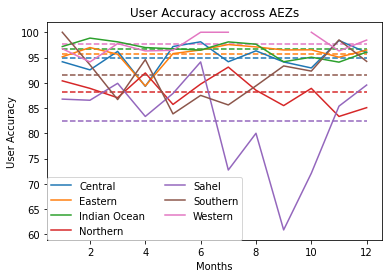

In [35]:
#means and standards
plt.hlines(np.mean(accuracies['Central']['User']),months[0], months[-1], linestyles='dashed', color='tab:blue')
#plt.hlines(np.mean(accuracies['Central']['User']) + np.std(accuracies['Central']['User']),months[0], months[-1], linestyles='dotted', color='tab:blue')
#plt.hlines(np.mean(accuracies['Central']['User']) - np.std(accuracies['Central']['User']),months[0], months[-1], linestyles='dotted', color='tab:blue')
plt.hlines(np.mean(accuracies['Eastern']['User']),months[0], months[-1], linestyles='dashed', color='tab:orange')
#plt.hlines(np.mean(accuracies['Eastern']['User']) + np.std(accuracies['Eastern']['User']),months[0], months[-1], linestyles='dotted', color='tab:orange')
#plt.hlines(np.mean(accuracies['Eastern']['User']) - np.std(accuracies['Eastern']['User']),months[0], months[-1], linestyles='dotted', color='tab:orange')
plt.hlines(np.mean(accuracies['IndianOcean']['User']),months[0], months[-1], linestyles='dashed', color='tab:green')
#plt.hlines(np.mean(accuracies['IndianOcean']['User']) + np.std(accuracies['IndianOcean']['User']),months[0], months[-1], linestyles='dotted', color='tab:green')
#plt.hlines(np.mean(accuracies['IndianOcean']['User']) - np.std(accuracies['IndianOcean']['User']),months[0], months[-1], linestyles='dotted', color='tab:green')
plt.hlines(np.mean(accuracies['Northern']['User']),months[0], months[-1], linestyles='dashed', color='tab:red')
#plt.hlines(np.mean(accuracies['Northern']['User']) + np.std(accuracies['Northern']['User']),months[0], months[-1], linestyles='dotted', color='tab:red')
#plt.hlines(np.mean(accuracies['Northern']['User']) - np.std(accuracies['Northern']['User']),months[0], months[-1], linestyles='dotted', color='tab:red')
plt.hlines(np.mean(accuracies['Sahel']['User']),months[0], months[-1], linestyles='dashed', color='tab:purple')
#plt.hlines(np.mean(accuracies['Sahel']['User']) + np.std(accuracies['Sahel']['User']),months[0], months[-1], linestyles='dotted', color='tab:purple')
#plt.hlines(np.mean(accuracies['Sahel']['User']) - np.std(accuracies['Sahel']['User']),months[0], months[-1], linestyles='dotted', color='tab:purple')
plt.hlines(np.mean(accuracies['Southern']['User']),months[0], months[-1], linestyles='dashed', color='tab:brown')
#plt.hlines(np.mean(accuracies['Southern']['User']) + np.std(accuracies['Southern']['User']),months[0], months[-1], linestyles='dotted', color='tab:brown')
#plt.hlines(np.mean(accuracies['Southern']['User']) - np.std(accuracies['Southern']['User']),months[0], months[-1], linestyles='dotted', color='tab:brown')
plt.hlines(np.nanmean(accuracies['Western']['User']),months[0], months[-1], linestyles='dashed', color='tab:pink')
#plt.hlines(np.nanmean(accuracies['Western']['User']) + np.nanstd(accuracies['Western']['User']),months[0], months[-1], linestyles='dotted', color='tab:pink')
#plt.hlines(np.nanmean(accuracies['Western']['User']) - np.nanstd(accuracies['Western']['User']),months[0], months[-1], linestyles='dotted', color='tab:pink')
#plot lines
plt.plot(months, accuracies['Central']['User'], label='Central')
plt.plot(months, accuracies['Eastern']['User'], label='Eastern')
plt.plot(months, accuracies['IndianOcean']['User'], label='Indian Ocean')
plt.plot(months, accuracies['Northern']['User'], label='Northern')
plt.plot(months, accuracies['Sahel']['User'], label='Sahel')
plt.plot(months, accuracies['Southern']['User'], label='Southern')
plt.plot(months, accuracies['Western']['User'], label='Western')
#plt.ylim(0,450)
plt.legend(ncol=2, loc='lower left', borderaxespad=0.)
plt.title('User Accuracy accross AEZs')
plt.xlabel('Months')
plt.ylabel('User Accuracy')
plt.savefig('All_AEZ_montly_user.png')
#plt.ylim(0,450)
plt.legend(ncol=2, loc='lower left', borderaxespad=0.)
plt.title('User Accuracy accross AEZs')
plt.xlabel('Months')
plt.ylabel('User Accuracy')


In [36]:
accuracies

{'Central': {'Producer': [76.33,
   78.38,
   76.51,
   68.49,
   88.03,
   91.76,
   94.85,
   94.93,
   87.27,
   78.63,
   87.68,
   86.86],
  'User': [94.16,
   92.55,
   96.21,
   89.29,
   97.17,
   98.11,
   94.16,
   96.32,
   94.12,
   92.93,
   98.37,
   95.97],
  'Overall': [81.47,
   81.33,
   79.53,
   72.64,
   90.17,
   92.61,
   92.5,
   93.85,
   87.26,
   83.59,
   90.59,
   89.25]},
 'Eastern': {'Producer': [88.89,
   86.1,
   86.84,
   75.0,
   86.81,
   89.8,
   86.96,
   85.17,
   86.27,
   83.26,
   84.15,
   85.71],
  'User': [95.14,
   96.97,
   95.65,
   89.36,
   95.77,
   96.49,
   97.56,
   97.1,
   96.49,
   96.52,
   95.06,
   96.48],
  'Overall': [89.01,
   87.02,
   86.32,
   80.81,
   87.65,
   88.89,
   88.05,
   86.6,
   87.13,
   86.23,
   84.84,
   85.5]},
 'Western': {'Producer': [68.99,
   53.33,
   67.97,
   59.09,
   48.21,
   56.0,
   100.0,
   nan,
   nan,
   90.0,
   88.14,
   85.81],
  'User': [96.74,
   94.12,
   97.75,
   96.3,
   96.43,


In [ ]:
# accuracy vs valid points

In [11]:
valid = pd.read_csv('../Results/WOfS_Assessment/Point_Based/Africa_s2_monthly_valid.csv',delimiter=",")

In [12]:
valid = valid.drop(['Unnamed: 0'], axis=1)

In [13]:
valid

,Indian_ocean,Central,Sahel,Southern,Northern,Eastern,Western
0,237,127,134,223,102,338,200
1,259,95,102,105,44,318,137
2,285,74,162,146,81,261,210
3,289,42,135,121,150,294,78
4,273,127,112,229,98,372,40
5,287,184,97,310,96,337,25
6,284,137,50,268,95,341,11
7,283,134,82,275,146,371,25
8,266,83,63,246,132,388,12
9,285,94,80,242,111,362,60


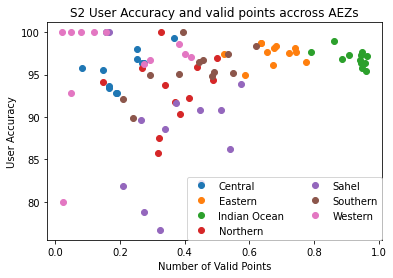

In [16]:
plt.plot(valid['Central']/500, accuracies['Central']['User'], 'o', label='Central')
plt.plot(valid['Eastern']/500, accuracies['Eastern']['User'], 'o', label='Eastern')
plt.plot(valid['Indian_ocean']/300, accuracies['Indian_ocean']['User'], 'o', label='Indian Ocean')
plt.plot(valid['Northern']/300, accuracies['Northern']['User'], 'o', label='Northern')
plt.plot(valid['Sahel']/300, accuracies['Sahel']['User'], 'o', label='Sahel')
plt.plot(valid['Southern']/500, accuracies['Southern']['User'], 'o', label='Southern')
plt.plot(valid['Western']/500, accuracies['Western']['User'], 'o', label='Western')
#plt.ylim(0,450)
plt.legend(ncol=2, loc='lower right', borderaxespad=0.)
plt.title('S2 User Accuracy and valid points accross AEZs')
plt.xlabel('Number of Valid Points')
plt.ylabel('User Accuracy')
plt.savefig('S2_All_AEZ_montly_user_valid.png')

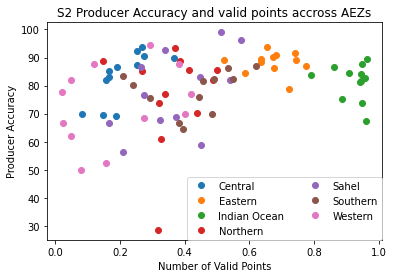

In [17]:
plt.plot(valid['Central']/500, accuracies['Central']['Producer'], 'o', label='Central')
plt.plot(valid['Eastern']/500, accuracies['Eastern']['Producer'], 'o', label='Eastern')
plt.plot(valid['Indian_ocean']/300, accuracies['Indian_ocean']['Producer'], 'o', label='Indian Ocean')
plt.plot(valid['Northern']/300, accuracies['Northern']['Producer'], 'o', label='Northern')
plt.plot(valid['Sahel']/300, accuracies['Sahel']['Producer'], 'o', label='Sahel')
plt.plot(valid['Southern']/500, accuracies['Southern']['Producer'], 'o', label='Southern')
plt.plot(valid['Western']/500, accuracies['Western']['Producer'], 'o', label='Western')
#plt.ylim(0,450)
plt.legend(ncol=2, loc='lower right', borderaxespad=0.)
plt.title('S2 Producer Accuracy and valid points accross AEZs')
plt.xlabel('Number of Valid Points')
plt.ylabel('Producer Accuracy')
plt.savefig('S2_All_AEZ_montly_producer_valid.png')

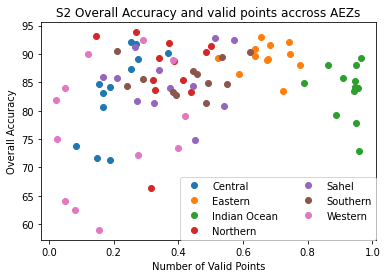

In [18]:
plt.plot(valid['Central']/500, accuracies['Central']['Overall'], 'o', label='Central')
plt.plot(valid['Eastern']/500, accuracies['Eastern']['Overall'], 'o', label='Eastern')
plt.plot(valid['Indian_ocean']/300, accuracies['Indian_ocean']['Overall'], 'o', label='Indian Ocean')
plt.plot(valid['Northern']/300, accuracies['Northern']['Overall'], 'o', label='Northern')
plt.plot(valid['Sahel']/300, accuracies['Sahel']['Overall'], 'o', label='Sahel')
plt.plot(valid['Southern']/500, accuracies['Southern']['Overall'], 'o', label='Southern')
plt.plot(valid['Western']/500, accuracies['Western']['Overall'], 'o', label='Western')
#plt.ylim(0,450)
plt.legend(ncol=2, loc='lower right', borderaxespad=0.)
plt.title('S2 Overall Accuracy and valid points accross AEZs')
plt.xlabel('Number of Valid Points')
plt.ylabel('Overall Accuracy')
plt.savefig('S2_All_AEZ_montly_overall_valid.png')

In [20]:
precip = pd.read_csv('../Results/WOfS_Assessment/Point_Based/Africa_monthly_precip.csv',delimiter=",")

In [21]:
precip = precip.drop(['Unnamed: 0'], axis=1)
precip

,Indian_ocean,Central,Eastern,Western,Northern,Southern,Sahel
0,364.001526,111.529556,61.937992,7.105752,13.050560,125.187798,0.939640
1,295.453918,109.959335,57.795429,17.357565,9.649271,114.293503,1.266432
2,204.608734,151.119598,93.691742,47.947758,10.401673,88.671356,4.273033
3,81.851707,138.760223,124.283401,83.289284,7.756573,37.226109,13.545053
4,43.772488,104.841606,83.889305,137.005692,5.368573,11.983806,24.311182
5,32.643108,75.198883,47.851944,185.272369,2.553499,7.902886,35.382240
6,28.995955,79.465546,66.048027,226.190872,0.830211,6.966878,65.989113
7,23.538925,98.417786,71.531181,254.688034,2.801752,7.131420,82.264099
8,23.631407,126.143661,53.464264,228.589188,6.448163,10.252178,48.200359
9,46.847881,177.149231,64.592583,139.306870,9.179540,29.821964,22.859110


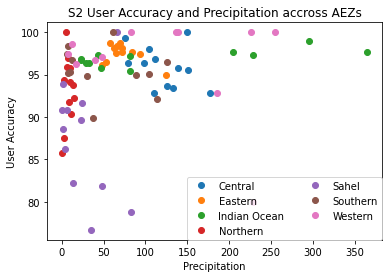

In [22]:
plt.plot(precip['Central'], accuracies['Central']['User'], 'o', label='Central')
plt.plot(precip['Eastern'], accuracies['Eastern']['User'], 'o', label='Eastern')
plt.plot(precip['Indian_ocean'], accuracies['Indian_ocean']['User'], 'o', label='Indian Ocean')
plt.plot(precip['Northern'], accuracies['Northern']['User'], 'o', label='Northern')
plt.plot(precip['Sahel'], accuracies['Sahel']['User'], 'o', label='Sahel')
plt.plot(precip['Southern'], accuracies['Southern']['User'], 'o', label='Southern')
plt.plot(precip['Western'], accuracies['Western']['User'], 'o', label='Western')
#plt.ylim(0,450)
plt.legend(ncol=2, loc='lower right', borderaxespad=0.)
plt.title('S2 User Accuracy and Precipitation accross AEZs')
plt.xlabel('Precipitation')
plt.ylabel('User Accuracy')
plt.savefig('S2_All_AEZ_montly_user_precip.png')

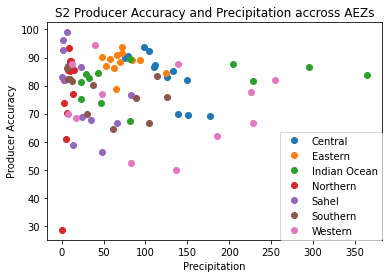

In [23]:
plt.plot(precip['Central'], accuracies['Central']['Producer'], 'o', label='Central')
plt.plot(precip['Eastern'], accuracies['Eastern']['Producer'], 'o', label='Eastern')
plt.plot(precip['Indian_ocean'], accuracies['Indian_ocean']['Producer'], 'o', label='Indian Ocean')
plt.plot(precip['Northern'], accuracies['Northern']['Producer'], 'o', label='Northern')
plt.plot(precip['Sahel'], accuracies['Sahel']['Producer'], 'o', label='Sahel')
plt.plot(precip['Southern'], accuracies['Southern']['Producer'], 'o', label='Southern')
plt.plot(precip['Western'], accuracies['Western']['Producer'], 'o', label='Western')
#plt.ylim(0,450)
plt.legend(ncol=1, loc='lower right', borderaxespad=0.)
plt.title('S2 Producer Accuracy and Precipitation accross AEZs')
plt.xlabel('Precipitation')
plt.ylabel('Producer Accuracy')
plt.savefig('S2_All_AEZ_montly_producer_precip.png')

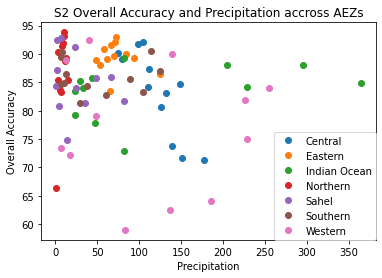

In [24]:
plt.plot(precip['Central'], accuracies['Central']['Overall'], 'o', label='Central')
plt.plot(precip['Eastern'], accuracies['Eastern']['Overall'], 'o', label='Eastern')
plt.plot(precip['Indian_ocean'], accuracies['Indian_ocean']['Overall'], 'o', label='Indian Ocean')
plt.plot(precip['Northern'], accuracies['Northern']['Overall'], 'o', label='Northern')
plt.plot(precip['Sahel'], accuracies['Sahel']['Overall'], 'o', label='Sahel')
plt.plot(precip['Southern'], accuracies['Southern']['Overall'], 'o', label='Southern')
plt.plot(precip['Western'], accuracies['Western']['Overall'], 'o', label='Western')
#plt.ylim(0,450)
plt.legend(ncol=1, loc='lower right', borderaxespad=0.)
plt.title('S2 Overall Accuracy and Precipitation accross AEZs')
plt.xlabel('Precipitation')
plt.ylabel('Overall Accuracy')
plt.savefig('S2_All_AEZ_montly_overall_precip.png')

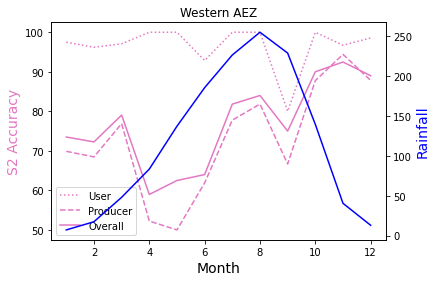

In [25]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(months, accuracies['Western']['User'], color='tab:pink', label = 'User', ls=':')
ax.plot(months, accuracies['Western']['Producer'], color='tab:pink', label = 'Producer', ls='--')
ax.plot(months, accuracies['Western']['Overall'], color='tab:pink', label = 'Overall')
ax.legend()
# set x-axis label
ax.set_xlabel("Month",fontsize=14)
# set y-axis label
ax.set_ylabel("S2 Accuracy",color="tab:pink",fontsize=14)
ax.set_title('Western AEZ')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(months, precip['Western'],color="blue")
ax2.set_ylabel("Rainfall",color="blue",fontsize=14)
plt.show()
# save the plot as a file
fig.savefig('S2_western_accuracy_rain.png',dpi=100,bbox_inches='tight')

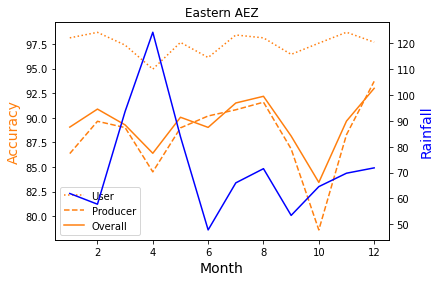

In [26]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(months, accuracies['Eastern']['User'], color='tab:orange', label = 'User', ls=':')
ax.plot(months, accuracies['Eastern']['Producer'], color='tab:orange', label = 'Producer', ls='--')
ax.plot(months, accuracies['Eastern']['Overall'], color='tab:orange', label = 'Overall')
ax.legend()
# set x-axis label
ax.set_xlabel("Month",fontsize=14)
# set y-axis label
ax.set_ylabel("Accuracy",color="tab:orange",fontsize=14)
ax.set_title('Eastern AEZ')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(months, precip['Eastern'],color="blue")
ax2.set_ylabel("Rainfall",color="blue",fontsize=14)
plt.show()
# save the plot as a file
fig.savefig('S2_Eastern_accuracy_rain.png',dpi=100,bbox_inches='tight')

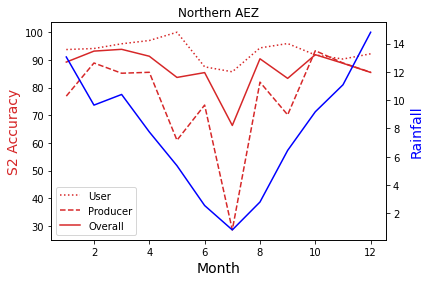

In [27]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(months, accuracies['Northern']['User'], color='tab:red', label = 'User', ls=':')
ax.plot(months, accuracies['Northern']['Producer'], color='tab:red', label = 'Producer', ls='--')
ax.plot(months, accuracies['Northern']['Overall'], color='tab:red', label = 'Overall')
ax.legend()
# set x-axis label
ax.set_xlabel("Month",fontsize=14)
# set y-axis label
ax.set_ylabel("S2 Accuracy",color="tab:red",fontsize=14)
ax.set_title('Northern AEZ')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(months, precip['Northern'],color="blue")
ax2.set_ylabel("Rainfall",color="blue",fontsize=14)
plt.show()
# save the plot as a file
fig.savefig('S2_Northern_accuracy_rain.png',dpi=100,bbox_inches='tight')

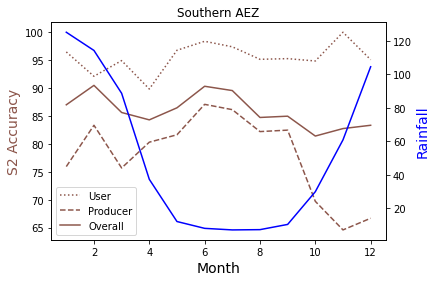

In [28]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(months, accuracies['Southern']['User'], color='tab:brown', label = 'User', ls=':')
ax.plot(months, accuracies['Southern']['Producer'], color='tab:brown', label = 'Producer', ls='--')
ax.plot(months, accuracies['Southern']['Overall'], color='tab:brown', label = 'Overall')
ax.legend()
# set x-axis label
ax.set_xlabel("Month",fontsize=14)
# set y-axis label
ax.set_ylabel("S2 Accuracy",color="tab:brown",fontsize=14)
ax.set_title('Southern AEZ')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(months, precip['Southern'],color="blue")
ax2.set_ylabel("Rainfall",color="blue",fontsize=14)
plt.show()
# save the plot as a file
fig.savefig('S2_Southern_accuracy_rain.png',dpi=100,bbox_inches='tight')

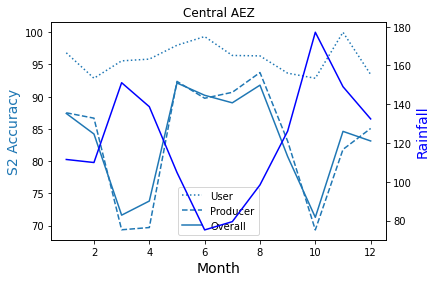

In [29]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(months, accuracies['Central']['User'], color='tab:blue', label = 'User', ls=':')
ax.plot(months, accuracies['Central']['Producer'], color='tab:blue', label = 'Producer', ls='--')
ax.plot(months, accuracies['Central']['Overall'], color='tab:blue', label = 'Overall')
ax.legend()
# set x-axis label
ax.set_xlabel("Month",fontsize=14)
# set y-axis label
ax.set_ylabel("S2 Accuracy",color="tab:blue",fontsize=14)
ax.set_title('Central AEZ')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(months, precip['Central'],color="blue")
ax2.set_ylabel("Rainfall",color="blue",fontsize=14)
plt.show()
# save the plot as a file
fig.savefig('S2_Central_accuracy_rain.png',dpi=100,bbox_inches='tight')

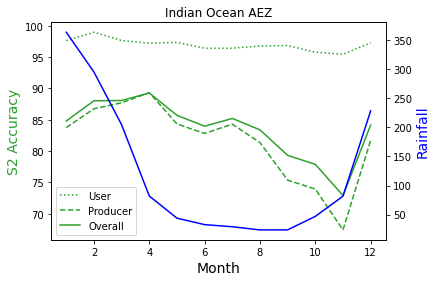

In [31]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(months, accuracies['Indian_ocean']['User'], color='tab:green', label = 'User', ls=':')
ax.plot(months, accuracies['Indian_ocean']['Producer'], color='tab:green', label = 'Producer', ls='--')
ax.plot(months, accuracies['Indian_ocean']['Overall'], color='tab:green', label = 'Overall')
ax.legend()
# set x-axis label
ax.set_xlabel("Month",fontsize=14)
# set y-axis label
ax.set_ylabel("S2 Accuracy",color="tab:green",fontsize=14)
ax.set_title('Indian Ocean AEZ')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(months, precip['Indian_ocean'],color="blue")
ax2.set_ylabel("Rainfall",color="blue",fontsize=14)
plt.show()
# save the plot as a file
fig.savefig('S2_Indian_ocean_accuracy_rain.png',dpi=100,bbox_inches='tight')

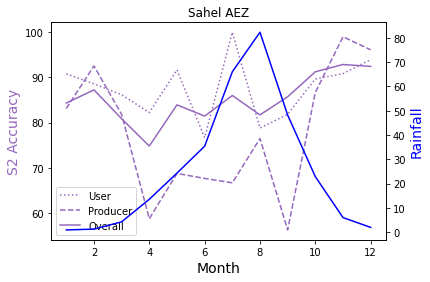

In [32]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(months, accuracies['Sahel']['User'], color='tab:purple', label = 'User', ls=':')
ax.plot(months, accuracies['Sahel']['Producer'], color='tab:purple', label = 'Producer', ls='--')
ax.plot(months, accuracies['Sahel']['Overall'], color='tab:purple', label = 'Overall')
ax.legend()
# set x-axis label
ax.set_xlabel("Month",fontsize=14)
# set y-axis label
ax.set_ylabel("S2 Accuracy",color="tab:purple",fontsize=14)
ax.set_title('Sahel AEZ')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(months, precip['Sahel'],color="blue")
ax2.set_ylabel("Rainfall",color="blue",fontsize=14)
plt.show()
# save the plot as a file
fig.savefig('S2_Sahel_accuracy_rain.png',dpi=100,bbox_inches='tight')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)